<a href="https://colab.research.google.com/github/fengfrankgthb/BUS-41204/blob/main/SL-1-2-HousePriceExample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction

Let's look at supervised learning in a classic ML course example: predicting house prices.

Our goal is going to build a prediction model to predict the sale price of a house based on easily observed features. The data are from the Seattle, WA area for a few months in 2014.



**------self note------**
* **formulaic**: The Python library that provides a formula-based API for describing statistical models, particularly for use with libraries like Patsy and statistical modeling packages in Python (e.g., statsmodels).
      
      # Create a design matrix predicting income from the
      # different levels of education (as dummy variables), and interaction
      # terms between age and the different levels of education.
      import pandas as pd
      from formulaic import model_matrix

      data = pd.DataFrame({
        'income': [20000, 30000, 40000, 50000],
        'education': ['High School', 'Bachelor', 'Master', 'PhD'],
        'age': [25, 35, 45, 55],
        'spending': [500, 800, 1200, 1500]
      })

      # Define a formula
      formula = 'spending ~ income + education + age:education'

      # Generate the design matrix using formulaic
      design_matrix = model_matrix(formula, data)

      print(design_matrix)


* **matplotlib.pyplot**: the collection of functions in the Matplotlib library that provide a MATLAB-like way of plotting static, interactive, and animated plots in Python. Plots styles includes: line, scatter, bar, histo, pie, box, violin, image...
* **seaborn**: a Python data visualization library built on top of Matplotlib for creating statistical graphics such as distribution plots, relational plots, matrix plot, regression plots, and categorical plots.

      # Create a scatter plot
      sns.scatterplot(x='sepal_length', y='sepal_width', hue='species', data=iris)
      plt.title('Sepal Length vs. Sepal Width by Species')
      plt.show()

      # Create a histogram
      sns.histplot(iris['petal_length'], kde=True)
      plt.title('Distribution of Petal Length')
      plt.show()

**------end note------**


We start by importing packages we will be using. See [our first example](https://colab.research.google.com/github/chansen776/MBA-ML-Course-Materials/blob/main/Code/BiasVarianceExample1.ipynb).


In [1]:
# Install extra libraries
!pip install formulaic
from formulaic import model_matrix

# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# Not the best practice, but we're going to suppress warnings for ease of display
# if we're looking at things during teaching
import warnings
warnings.filterwarnings("ignore") # drop warning messages that don't stop model processing

# Seed we will use for random number generators
rng = 713


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 3.3 MB/s eta 0:00:00


# Load and examine the data

We need to load the data. We will do this directly from a github repository for the course.

In [2]:
file = "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/main/Data/WAHousePrice.xlsx"
data = pd.read_excel(file)
data.shape  # See size of dataset

(4551, 18)

Let's take a look at what's in the data

In [3]:
data.columns

Index(['date', 'price', 'bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [4]:
data.describe()

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4551,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,2014-06-07 03:59:12.537903872,5.579059e+05,2.155021,3.394639,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.795649,808.564052
min,2014-05-02 00:00:00,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,2014-05-21 00:00:00,3.262643e+05,1.750000,3.000000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,2014-06-09 00:00:00,4.650000e+05,2.250000,3.000000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,2014-06-24 00:00:00,6.575000e+05,2.500000,4.000000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000
max,2014-07-10 00:00:00,2.659000e+07,8.000000,9.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000
std,NaN,5.639299e+05,0.776351,0.904595,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,29.760073,979.421487


The maximum price 2.659000e+07 = 26,590,000 seems very high. We'll look at this again in a second. There are also some very low prices and properties with 0 bedrooms and bathrooms. Nothing else in the summary statistics stands out as particularly noteworthy.

Do the the square footage variables `sqft_living`, `sqft_above` and `sqft_basement` capture different information?

In [5]:
# Let's calculate the correlation of sqft_living with sqft_above+sqft_basement
print('Correlation of sqft_living with (sqft_above+sqft_basement):',
      data['sqft_living'].corr(data['sqft_above']+data['sqft_basement']))

# Let's calculate the correlation with each element instead
print('Correlation of sqft_living with sqft_above:',
      data['sqft_living'].corr(data['sqft_above']))
print('Correlation of sqft_living with sqft_basement:',
      data['sqft_living'].corr(data['sqft_basement']))


Correlation of sqft_living with (sqft_above+sqft_basement): 1.0
Correlation of sqft_living with sqft_above: 0.8756565340919786
Correlation of sqft_living with sqft_basement: 0.44967103186276847


Cannot use `sqft_living` and both `sqft_basement` and `sqft_above` in the same linear model estimated by least squares (or least absolute values).

**Question:** How do we choose which to use?

**Frank Note**: USe either sqft_living AND sqft_basement.

Let's quickly examine the 0 bedroom and 0 bathroom observations.

In [6]:
# Let's find the observations with 0 bedrooms or 0 bathrooms and see what they look like
data[(data['bedrooms'] == 0) | (data['bathrooms'] == 0)]

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1750,2014-06-12,1095000.0,0.0,0,3064,4764,3.5,0,2,3,3064,0,1990,2009,814 E Howe St,Seattle,WA 98102,USA
2394,2014-06-24,1295648.0,0.0,0,4810,28008,2.0,0,0,3,4810,0,1990,2009,20418 NE 64th Pl,Redmond,WA 98053,USA


I'm pretty confident that houses with 3000+ square feet of living space should have bathrooms and bedrooms. We could try to *impute* what seem to be the missing values of bathrooms and bedrooms for these two observations. Because it's only two observations, I'm just going to delete them instead.

In [7]:
# Drop the flagged observations
data = data.drop(data[(data['bedrooms'] == 0) | (data['bathrooms'] == 0)].index)

In [8]:
data.dtypes

,0
date,datetime64[ns]
price,float64
bathrooms,float64
bedrooms,int64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64
condition,int64


Some of the variables `street`, `city`, `statezip`, and `country` are not numeric, so don't show up in the summary table. We'll look at these variables after examining the outcome in a bit more detail.

**Outcome variable**

Let's start by seeing what the outcome variable looks like.

**------self note------**

sns.displot() is one variable histograms, with density/frequency as vertical axis.

plt.scatter(x,y) is two variables plot, showing visual correlation if any.

**------end note------**

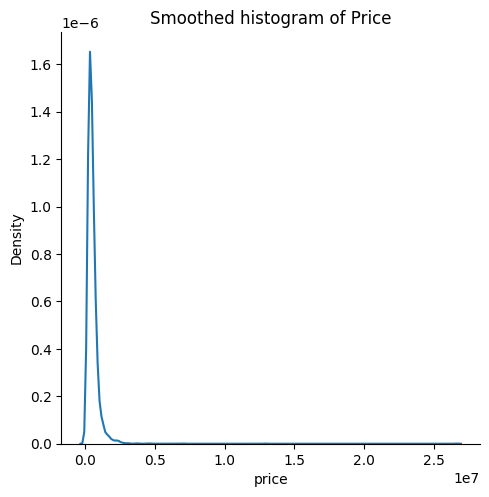

In [9]:
# Smoothed histogram of the outcome variable, price
sns.displot(data=data, x='price', kind='kde')
plt.title('Smoothed histogram of Price')
plt.show()

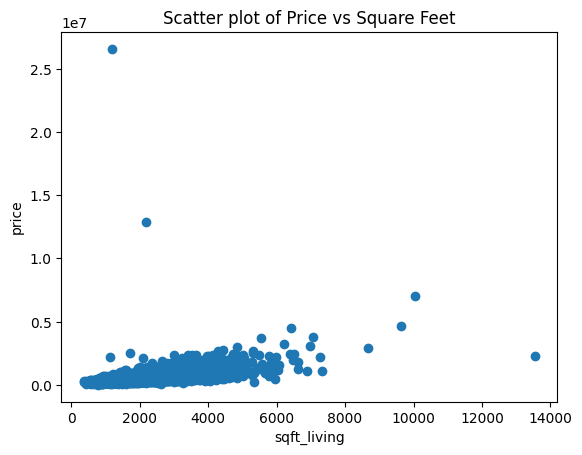

In [10]:
plt.scatter(data['sqft_living'], data['price'])
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Scatter plot of Price vs Square Feet')
plt.show()

There are two observations that are probably worth another look. Also recall that there was at least one very low price from the summary statistics. Let's look at both.

In [11]:
# Let's find the observations with very low prices and see what they look like
data[data['price'] < 50000]

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
3215,2014-05-06,7800.0,1.0,2,780,16344,1.0,0,0,1,780,0,1942,0,4229 S 144th St,Tukwila,WA 98168,USA


It seems a bit out of the realm of possibility to have a $7800 dollar property in the Seattle area in 2014, though the property seems not particularly desirable. I'm going to assume that the price here is incorrect.

In [12]:
# Let's find the observations with very high prices and see what they look like
data[data['price'] > 5000000]


,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1693,2014-06-11,7062500.0,4.5,5,10040,37325,2.0,1,2,3,7680,2360,1940,2001,4442 95th Ave NE,Bellevue,WA 98004,USA
3211,2014-06-23,12899000.0,2.5,3,2190,11394,1.0,0,0,3,1550,640,1956,2001,5426 40th Ave W,Seattle,WA 98199,USA
3214,2014-07-03,26590000.0,2.0,3,1180,7793,1.0,0,0,4,1180,0,1992,0,12005 SE 219th Ct,Kent,WA 98031,USA


I can believe that a 10000 square foot property sold for \$7M.

I have a hard time believing a 2 bathroom, 3 bedroom, 1180 square foot property sold for ~\$27M. This seems like a mistake. I'm also having a hard time believing that a 2.5 bathroom, 3 bedroom, 2190 square foot property sold for ~\$13M.

I am going to treat both of these observations as "mistakes" and drop them from my data. I am going to recognize that if these are real observations, there is a small chance I will see future properties that I make GIGANTIC mistakes on.

We can/should also run the whole thing with the dropped observations included to gauge robustness.

In [13]:
# Drop the flagged observations
data = data.drop(data[data['price'] < 50000].index)
data = data.drop(data[data['price'] > 10000000].index)

Our price variable is highly skewed. It is very commeon to see data-scientists build models a right-skewed variable that only takes on positive values by taking a `log` transformation first. I.e. instead by building a model for `price`, we might instead build a model for `log(price)`.

**Remember that our goal is to predict `price` though!** Make sure you validate on the basis of what you care about.

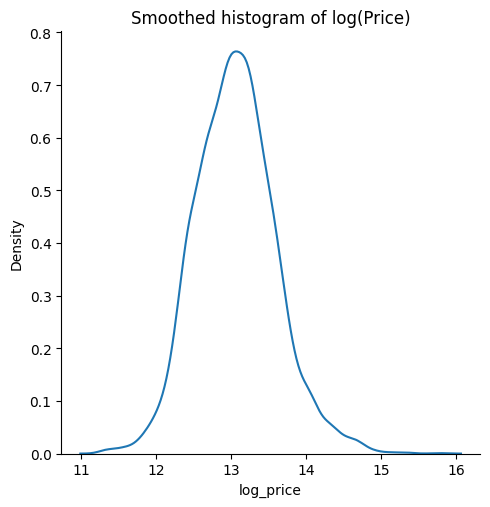

In [14]:
# Create new column with the log of price
data['log_price'] = np.log(data['price'])

# Smoothed histogram of log price
sns.displot(data=data, x='log_price', kind='kde')
plt.title('Smoothed histogram of log(Price)')
plt.show()

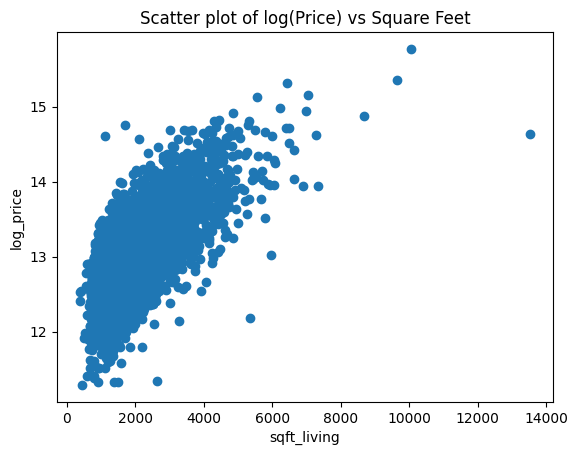

In [15]:
plt.scatter(data['sqft_living'], data['log_price'])
plt.xlabel('sqft_living')
plt.ylabel('log_price')
plt.title('Scatter plot of log(Price) vs Square Feet')
plt.show()

What happens if we look at log(`sqft_living`)?

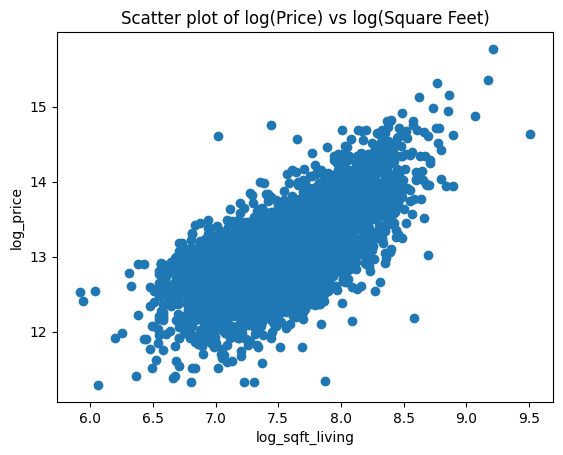

In [16]:
plt.scatter(np.log(data['sqft_living']), data['log_price'])
plt.xlabel('log_sqft_living')
plt.ylabel('log_price')
plt.title('Scatter plot of log(Price) vs log(Square Feet)')
plt.show()

That actually looks pretty reasonable. Let's consider using the log of all our square footage variables.

**------self note------**

Code above creates plots with log(price), but doesn't create data column for log(price).

Code below replaces the data column sqft_living, sqft_lot and sqft_above with their logistic values respectively.

**------end note------**

In [ ]:
# Replace square footage variables with their log
data['sqft_living'] = np.log(data['sqft_living'])
data['sqft_lot'] = np.log(data['sqft_lot'])
data['sqft_above'] = np.log(data['sqft_above'])

In [18]:
# sqft_basement has 0 values that indicate no basement. We don't want to replace those
data.loc[data["sqft_basement"] > 0, "sqft_basement"] = np.log(data.loc[data["sqft_basement"] > 0, "sqft_basement"])

**Categorical Variables**

The four variables of type "object" are not numeric but coded as text. Let's look at what they are. In the following code blocks, we are just going to tabulate each of our categorical variables by looking at the `value_counts` property of our data.

In [19]:
data['street'].value_counts()

,count
street,
2520 Mulberry Walk NE,4
2500 Mulberry Walk NE,3
26007 SE 27th St,2
1273 NE Hickory Ln,2
3715 NE 153rd St,2
...,...
12439 235th Pl NE,1
16718-16726 171st Pl NE,1
16433 12th Ave SW,1


Most street addresses have only one property. Without better geographic knowledge, it's going to be hard to use this variable.

**Question:** If you really cared, how could you use the street address to get something potentially more useful? (Think about, e.g., google street view, google maps and routing, ...)

**Frank answer**: To predicting price, street address can be used to generate longitude-latitude for map location, than further classified to regions.

In [20]:
data['city'].value_counts()

,count
city,
Seattle,1559
Renton,291
Bellevue,281
Redmond,234
Kirkland,187
Issaquah,186
Kent,183
Auburn,175
Sammamish,171


In [21]:
np.sum(data['city'].value_counts() < 20)

np.int64(15)

City might be useful, but it is very unbalanced.

**Questions:**

1. Do we think the actual name of the city matters? Why might the variable `city` contain useful information?

2. If we want to predict something outside of the Seattle area, is the variable `city` useful? Could we make it useful with some more effort?

**Frank answer**:

1. City name matters in that it tells basic economics in the area. There are multiple Richmonds in US. But typically, one city names are not duplicated in one State.

2. To predict price outside Seattle, useful information can be the informaiton from the cityskirts of Seattle. Alternatively, we could use price gradient against distance from center along the direction inside the nearby city to predict its outside.

In [22]:
data['statezip'].value_counts()

,count
statezip,
WA 98103,148
WA 98052,135
WA 98117,132
WA 98115,129
WA 98006,109
...,...
WA 98047,6
WA 98288,3
WA 98354,2


Zip code (`statezip`) seems like it might have more *interesting* variation than `city`.

**Questions:**

1. Do we think the actual numeric value of a property's zip code matters? Why might the variable `statezip` contain useful information?

2. If we want to predict something outside of the Seattle area, is the variable `statezip` useful? Could we make it useful with some more effort?

**Frank Answer**

1. Numberical zipvalue may matter most when relating to geo location. Otherwise, it may be less valuable in regression models. However, it may be very valueble for neural networks.

In [23]:
data['country'].value_counts()

,count
country,
USA,4546


Can't use the variable `country` - It doesn't *vary* 🙂.

**Aside: Categorical Variables.**

The typical way to use (unordered) categorical variables is to encode them as dummy variables/binary variables/use one-hot-encoding --  all of which are jargon for making a new set of variables that are 0 or 1 with 1 indicating the observation belongs to a category and 0 indicates it does not.

For example, if we had a variable `color` with two categories "red" and "blue", we just create two new variables `red` and `blue` where variable `red` = 1 for all observations that are red (and 0 otherwise) and `blue` is defined similarly. (Note: For standard linear models, you typically exclude one of the dummy variables. In our toy example, we don't need both the variables `red` and `blue` because if `red` = 1 we know `blue` = 0 and viceversa. That is, they have the same information.)

We'll look at doing this in our price example when we consider including `city` and `statezip` in our model.

Before doing anything else, let's drop the variables we definitely won't use.

In [24]:
data = data.drop(columns=['date','street','country'])

Finally, we also see that we have many other variables that are effectively capturing qualitative information or a mix. E.g. `bathrooms`, `bedrooms`, `floors`, `waterfront`, `view`, and `condition` might be thought of as categorical.

Let's look at these variables more carefully.

In [25]:
print(data['bathrooms'].value_counts())
print('\n')
print(data['bedrooms'].value_counts())
print('\n')
print(data['floors'].value_counts())
print('\n')
print(data['waterfront'].value_counts())
print('\n')
print(data['view'].value_counts())
print('\n')
print(data['condition'].value_counts())

bathrooms
2.50    1183
1.00     735
1.75     628
2.00     424
2.25     413
1.50     287
2.75     270
3.00     164
3.50     159
3.25     135
3.75      34
4.50      26
4.25      22
4.00      21
0.75      17
4.75       7
5.00       5
5.50       4
5.25       4
1.25       3
8.00       1
5.75       1
6.50       1
6.25       1
6.75       1
Name: count, dtype: int64


bedrooms
3    2023
4    1512
2     560
5     338
6      59
1      37
7      14
8       2
9       1
Name: count, dtype: int64


floors
1.0    2148
2.0    1790
1.5     439
3.0     127
2.5      41
3.5       1
Name: count, dtype: int64


waterfront
0    4516
1      30
Name: count, dtype: int64


view
0    4099
2     200
3     115
1      69
4      63
Name: count, dtype: int64


condition
3    2848
4    1237
5     425
2      31
1       5
Name: count, dtype: int64


Importantly, these variables all have an order to them. `bathrooms`, `bedrooms`, and `floors` also (arguably) have cardinal value. `view` and `condition` are clearly qualitative, but do have ordinal meaning. `waterfront` is already a dummy variable.

We could treat these by including them as dummy variables, but it also makes sense to use them as is (which is what we are going to do). Many ML procedures will happily and appropriately deal with ordered categorical features and numeric features with few values.

**Mixed variables**

The variables `sqft_basement` and `yr_renovated` have a 0 category indicating "no basement" or "never renovated" respectively.

We can add variables indicating the qualitative information. For many learners, adding this variable is also unnecessary.

In [26]:
# Add a variable for being renovated
data['renovated_flag'] = np.where(data['yr_renovated'] == 0, 0, 1)

# Add a variable for having a basement
data['basement_flag'] = np.where(data['sqft_basement'] == 0, 0, 1)

# Model evaluation

We are going to use 5-fold CV to evaluate our models. We want to keep the cross-validation folds the same across all of the models we build, so we're going to predefine the splits.

In [27]:
cvsplit = KFold(n_splits=5, shuffle=True, random_state=rng)

We also need to choose how to evaluate the models. For illustration, we're going to consider performance based on both MAE and MSE. We are going to estimate models using both `price` and `log_price` for illustration.

When we build a model for `log_price`, we don't directly build a prediction rule for `price`. We are going to use the simplest approach to turning our `log_price` prediction into a `price` prediction by exponentiating. I.e. if $\widehat{\texttt{log_price}}$ is our prediction for `log_price`, we obtain a prediction for `price` as $\exp\{\widehat{\texttt{log_price}}\}$.

We're going to define functions to produce MSE and MAE from `log_price` predictions.

**------self note------**

**expmse(y_true, y_pred)**: Define a custom function of ExpMSE of a y_pred and y_true that calculates the MSE between exp(y-true) and exp(y_pred). The return value of negmse will be the the result of the function ExpMSE.

**make_scorer(expmse)**: A function from sklearn.metrics module to convert custome loss function expmse into a score object. Results are used in cross_val_score, GridSearchCV, and Randomized SearchCV.

**------end note------**

In [ ]:
def expmse(y_true, y_pred):

  y_true = y_true.to_numpy()
  y_pred[y_pred < -20] = -20
  y_pred[y_pred > 20] = 20 # Prevent overflow issues in really bad models because we are going to exponentiate
  negmse = -np.mean((np.exp(y_true) - np.exp(y_pred))**2)

  return negmse

# Create a scorer object using the expmse function
expmse_score = make_scorer(expmse)

def expmae(y_true, y_pred):

  y_true = y_true.to_numpy()
  y_pred[y_pred < -20] = -20
  y_pred[y_pred > 20] = 20 # Prevent overflow issues in really bad models because we are going to exponentiate
  negmae = -np.mean(np.abs(np.exp(y_true) - np.exp(y_pred)))

  return negmae

# Create a scorer object using the expmae function
expmae_score = make_scorer(expmae)


# Baseline start

As simple benchmark, let's look at sample means and medians.

We're going to define functions for using the mean and median as prediction rules that we can use with `sklearn`'s built in cross-validation functions.

In [ ]:
# Define function to use mean as estimator and make prediction
class MeanEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        # Compute the mean of y during fitting
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        # Return the mean for all predictions
        return np.full(len(X), self.mean_)

# Define function to use median as estimator and make prediction
class MedianEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        # Compute the mean of y during fitting
        self.median_ = np.median(y)
        return self

    def predict(self, X):
        # Return the mean for all predictions
        return np.full(len(X), self.median_)


Let's look at how well the sample mean and sample median of `price` do for predicting `price` by 5-fold cross-validation.

In [ ]:
# Cross validation RMSE and MAE using sample mean of price as prediction rule
# The "scoring" argument tells cross-validation what out-of-sample prediction
# metrics to compute.
levmean_mse = cross_validate(MeanEstimator(), data['price'], data['price'],
                             scoring=('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Mean: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-levmean_mse['test_neg_mean_squared_error'].mean()),
          m2=-levmean_mse['test_neg_mean_absolute_error'].mean()))

# Cross validation RMSE and MAE using sample median of price as prediction rule
# The "scoring" argument tells cross-validation what out-of-sample prediction
# metrics to compute.
levmedian_mse = cross_validate(MedianEstimator(), data['price'], data['price'],
                               scoring=('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Median: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-levmedian_mse['test_neg_mean_squared_error'].mean()),
          m2=-levmedian_mse['test_neg_mean_absolute_error'].mean()))

# We are going to use cross-validated MSE from the mean as our benchmark for MSE
# We are going to use cross-validated MAE from the median as our benchmark for MAE
benchMSE = -levmean_mse['test_neg_mean_squared_error'].mean()
benchMAE = -levmedian_mse['test_neg_mean_absolute_error'].mean()

In [ ]:
# Let's create a table to keep track of results
model_results = pd.DataFrame()
model_results['Model'] = ['Mean', 'Median']
model_results['RMSE'] = [np.sqrt(-levmean_mse['test_neg_mean_squared_error'].mean()),
                         np.sqrt(-levmedian_mse['test_neg_mean_squared_error'].mean())]
model_results['R2 - MSE'] = [None,None]
model_results['MAE'] = [-levmean_mse['test_neg_mean_absolute_error'].mean(),
                        -levmedian_mse['test_neg_mean_absolute_error'].mean()]
model_results['R2 - MAE'] = [None,None]
model_results['p'] = [None,None]
model_results['p_use'] = [None,None]
model_results

# Baseline linear models.

## Think about the model

For black box machine learners that discover nonlinearity automatically, thinking about how to model nonlinearity and other transformations to make of our available variables is not a big issue. The ability to put less time into  thinking about these issues is a major plus for ML algorithms. **You should always be thoughtful about variables in a model though.**

For learners like linear regression, thinking about the appropriate way to include variables is potentially very important though.


## Baseline models: OLS

For our baseline models, we are going to repeatedly apply the same steps. Let's write some functions so we don't have to keep typing the same things.

In [ ]:
def perform_cross_validation(model, X, y, scoring, cvsplit, benchMSE, benchMAE, p):

    results = cross_validate(model, X, y, scoring=scoring, cv=cvsplit)

    rmse = np.sqrt(-results['test_mse'].mean())
    r2 = 1 - (-results['test_mse'].mean() / benchMSE)
    mae = -results['test_mae'].mean()
    mae_r2 = 1 - (-results['test_mae'].mean() / benchMAE)
    print(f'CV RMSE: {rmse:.2f}; CV R2: {r2:.3f}; p: {p:.0f}')
    print(f'CV MAE: {mae:.2f}; CV MAE R2: {mae_r2:.3f}; p: {p:.0f}')

    return results

def update_model_results(model_results, model_name, results, p, p_use):

    rmse = np.sqrt(-results['test_mse'].mean())
    r2 = 1 - (-results['test_mse'].mean() / benchMSE)
    mae = -results['test_mae'].mean()
    mae_r2 = 1 - (-results['test_mae'].mean() / benchMAE)
    model_results = model_results._append({
        'Model': model_name,
        'RMSE': rmse,
        'R2 - MSE': r2,
        'MAE': mae,
        'R2 - MAE': mae_r2,
        'p': p,
        'p_use': p_use }, ignore_index=True)

    return model_results


We are going to keep track of MSE and MAE for price. Let's define the metrics we're looking at.

In [ ]:
# Evaluation metrics
scoring_lev = {'mse': 'neg_mean_squared_error',
               'mae': 'neg_mean_absolute_error'}

scoring_log = {'mse': expmse_score,
               'mae': expmae_score}

We're going to use the "formula" interfact we imported from formulaic to help define our models.

The basics we will use:
1. Putting a variable inside "C" will make the variable be treated as categorical by turning it into dummy variables.
2. Putting a variable inside "poly" will create a polynomial of "degree" in that variable
3. Putting a : between variables creates the interaction between those variables
4. Putting a * between variables includes the variables and their interactions


In [ ]:
# Linear terms in all baseline variables
pure = ("price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + yr_built + yr_renovated + renovated_flag + basement_flag")

# Create variables based on model defined in formula
y, X = model_matrix(pure, data)
n, p_pure = X.shape

# Outcome variable for log models
logy = data['log_price']

We're now going to estimate and evaluate our baseline model for `price` and for `log_price` using the five fold cross-validation splits defined [above](https://colab.research.google.com/github/chansen776/MBA-ML-Course-Materials/blob/main/Code/HousePriceExample1.ipynb#scrollTo=FCFKawjSMkvH&line=1&uniqifier=1).



In [ ]:
# Basic regression for price
purelm = perform_cross_validation(LinearRegression(), X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_pure)
model_results = update_model_results(model_results, 'LM', purelm, p_pure, p_pure)

# Basic regression for log-price
pureloglm = perform_cross_validation(LinearRegression(), X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_pure)
model_results = update_model_results(model_results, 'logLM', pureloglm, p_pure, p_pure)

**Nonlinearity**

We should think about potential *nonlinearities* that we would like to allow our models to capture. For example, do we think that each unit increase in house's square footage at fixed values of other variables should be associated with the same change in predicted (log) price regardless of the square footage? E.g. do we think going from 1000 to 1100 square feet is the same "value" as going from 3000-3100 square feet? Do we think the "value" of going from 2000-2100 square feet is the same if we are talking about a three versus five bedroom property?

A very simple and interpretable way to allow for nonlinearities is to use *polynomials* and *interactions*. E.g. we might include `sqft_living` and `sqft_living`$^2$ to allow for decreasing or increasing "returns" to square footage in our model, so our prediction rule would be

$$\widehat{\texttt{price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + ...$$

or

$$\widehat{\texttt{log_price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + ...$$

[Note that you cannot interpret $b_1$ and $b_2$ in isolation.]

We might also include the *interaction* `sqft_living`*`bedrooms` to allow the predicted price change for a given change in `sqft_living` to be different for properties with different numbers of bedrooms. In this case, our model would be

$$ \widehat{\texttt{price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + b_3\texttt{bedrooms} + b_4 \texttt{sqft_living}*\texttt{bedrooms} + ...$$

or

$$ \widehat{\texttt{log_price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + b_3\texttt{bedrooms} + b_4 \texttt{sqft_living}*\texttt{bedrooms} + ...$$

[Note that you cannot interpret $b_1$, $b_2$, $b_3$, and $b_4$ in isolation.]

In our baseline prediction rules we will include squares of all "numeric" variable and include the interaction of `sqft_living` with `bedrooms` and with `bathrooms`

Let's add some terms to try to capture nonlinearity if there is any.

In [ ]:
# Baseline model. Quadratic in all continuous variables and interaction between
# sqft_living and bedrooms and bathrooms

base = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(renovated_flag) + C(basement_flag)"
            " + sqft_living:(bedrooms+bathrooms)")

# Create variables based on model defined in formula
y, X = model_matrix(base, data)
n, p_base = X.shape

# Outcome variable for log models
logy = data['log_price']

In [ ]:
# Baseline regression for price
baselm = perform_cross_validation(LinearRegression(), X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_base)
model_results = update_model_results(model_results, 'Baseline LM', baselm, p_base, p_base)

# Baseline regression for log-price
baseloglm = perform_cross_validation(LinearRegression(), X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_base)
model_results = update_model_results(model_results, 'Baseline logLM', baseloglm, p_base, p_base)


Not bad. Both models are a sizeable improvement relative to the simple sample mean or median.

Let's look at the `log_price` model refit using the entire dataset in more detail.

In [ ]:
model = sm.OLS(logy, X)
result = model.fit(cov_type='HC3')  # cov_type = 'HC3' computes specification robust standard errors
print(result.summary())

print('\n')
pred_err = result.resid
print("RMSE of model: ", np.sqrt(np.mean(pred_err**2)))
print('\n')

**Questions:**

1. How does the reported $R^2$ relate to the CV $R^2$?
2. What does the reported RMSE mean?
3. How does `sqft_living` relate to the `log_price` prediction? (Ask ChatGPT and see if it gets it right. The last time I tried it was close but not perfect.)

A useful way to think about gauging how variables relate to predictions is just to probe the rule by predicting at some values of interest. This can be especially useful for black-box prediction rules.

Let's specifically look at 2000 vs 2100 square feet and 4 vs 5 bedrooms

In [ ]:
newX = pd.DataFrame(columns = X.columns)
newX = newX._append(X.iloc[125]) # Observation with a 2.5 bathroom, 4 bedroom, 2000 square foot house
newX = pd.DataFrame(np.repeat(newX.values, 4, axis=0))
newX.columns = X.columns
newX.iloc[1,5] = np.log(2100)
newX.iloc[1,6] = np.log(2100)**2
newX.iloc[1,22] = 4*np.log(2100)
newX.iloc[1,23] = 2.5*np.log(2100)
newX.iloc[2,3] = 5
newX.iloc[2,4] = 5**2
newX.iloc[2,22] = 5*np.log(2000)
newX.iloc[3,3] = 5
newX.iloc[3,4] = 5**2
newX.iloc[3,5] = np.log(2100)
newX.iloc[3,6] = np.log(2100)**2
newX.iloc[3,22] = 5*np.log(2100)
newX.iloc[3,23] = 2.5*np.log(2100)

# Predicted log prices for our four hypothetical houses
yhat = result.predict(newX)
print('Difference in predicted log(price) 2100 vs 2000 sqft (4 beds):', yhat[1]-yhat[0])
print('Difference in predicted log(price) 2100 vs 2000 sqft (5 beds):', yhat[3]-yhat[2])
print('Difference in predicted log(price) 4 vs 5 beds (2000 sqft):', yhat[2]-yhat[0])
print('Difference in predicted log(price) 4 vs 5 beds (2100 sqft):', yhat[3]-yhat[1])
print('\n')
print('Difference in predicted price 2100 vs 2000 sqft (4 beds):', np.exp(yhat[1])-np.exp(yhat[0]))
print('Difference in predicted price 2100 vs 2000 sqft (5 beds):', np.exp(yhat[3])-np.exp(yhat[2]))
print('Difference in predicted price 4 vs 5 beds (2000 sqft):', np.exp(yhat[2])-np.exp(yhat[0]))
print('Difference in predicted price 4 vs 5 beds (2100 sqft):', np.exp(yhat[3])-np.exp(yhat[1]))



# Baseline linear models: LAV regression

We can run least absolute values regression using `sklearn`'s `QuantileRegressor`. We're still evaluation models based on 5-fold cross-validation using our previously defined splits.

In [ ]:
model = make_pipeline(StandardScaler(), QuantileRegressor(alpha = 0, solver = 'highs-ds'))
# Lots of learners work best with variables on a common scale. StandardScaler()
# standardizes the data. The pipeline is going to standardize before running
# the quantile regression.

# LAV regression for price
baseqr = perform_cross_validation(model, X, y.to_numpy().ravel(),
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_base)
model_results = update_model_results(model_results, 'Baseline LAV', baseqr, p_base, p_base)

# LAV regression for log-price
baselogqr = perform_cross_validation(model, X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_base)
model_results = update_model_results(model_results, 'Baseline logLAV', baselogqr, p_base, p_base)


# A More Flexible Model

Maybe we haven't captured all the nonlinearity with our quadratic polynomials. Maybe there are interactions between variables besides the couple we thought about (`sqft_living` with `bedrooms` and `bathrooms`).

Let's try a more elaborate model.

In [ ]:
# Specify model as formula
flex = ("price ~ poly(bathrooms, degree=4, raw=True) + poly(bedrooms, degree=4, raw=True)"
             " + poly(sqft_living, degree=6, raw=True) + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag)"
             " + poly(bathrooms, degree=4, raw=True):(poly(bedrooms, degree=4, raw=True)"
             " + poly(sqft_living, degree=6, raw=True) + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(bedrooms, degree=4, raw=True):(poly(sqft_living, degree=6, raw=True)"
             " + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(sqft_living, degree=6, raw=True):(poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(sqft_lot, degree=4, raw=True):(poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(floors, degree=4, raw=True):(waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + waterfront:(C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + C(view):(C(condition) + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + C(condition):(poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(yr_built, degree=4, raw=True):(poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(yr_renovated, degree=4, raw=True):(C(renovated_flag) + C(basement_flag))"
             " + C(renovated_flag):C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(flex, data)
n, p_flex = X.shape

# Outcome variable for log models
logy = data['log_price']

Let's run our more flexible model and see how it does according to 5-Fold CV.

In [ ]:
model = make_pipeline(StandardScaler(), LinearRegression())
# Lots of learners work best with variables on a common scale. StandardScaler()
# standardizes the data. This can be very important with high order polynomials.

# Regression for price from flexible model
flexlm = perform_cross_validation(model, X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_flex)

# Regression for log-price from flexible model
flexloglm = perform_cross_validation(model, X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_flex)


**Aside:** I cheated in my definition of the scorer for the log models to prevent numeric issues in silly models (like this one). The actual performance is much worse.

We're not going to add these performance metrics to our table because they're awful and make the table unreadable.

It looks like the flexible model does a really bad job.

**Questions:**
1. I'm only showing validation sample performance measures. How do we think in-sample validation measures line up?
2. Does the very poor validation performance of the "interactions" model mean nothing in the model adds predictive power beyond the other models?
3. Are we sure we have tried everything we want? There are lots of "intermediate" models?
4. Should we have even more interactions or allow for higher order nonlinearity? How do we specify all the choices?

## Lasso

A popular approach to estimating linear models when there are many potential variables is the *Lasso*.

Recall that conventional linear model estimates are obtained by solving

$$\min \sum_{i} (y_i - b_0 - b_1 X_1 - ... - b_p X_p)^2$$

where the sum is over all observations in the training data. That is, we try to find the linear prediction rule for $Y$ that is as close as possible to $Y$ in the training data.

Lasso solves a similar problem

$$\min \sum_{i} (y_i - b_0 - b_1 X_1 - ... - b_p X_p)^2 + \lambda \sum_j |b_j|.$$

The key thing we have added is a *penalty term* $\lambda \sum_j |b_j|$. Intuitively, this penalty says that if you want to move a coefficient $b_j$ away from 0 to improve the in-sample fit, you also have to pay a cost introduced by the penalty term.

In practice, the presence of the penalty may lead to variables being excluded from the model. Intuitively, if the benefit of moving a $b_j$ away from 0 is smaller than the cost, the coefficient will be left at 0.

When we do Lasso, we have to choose the *tuning parameter* $\lambda$ which controls the cost of increasing the size of coefficients. We choose $\lambda$ by trying several values and choosing the best according to cross-validation (or just validation).

[Aside: There are MANY other penalized regression procedures. Another popular one is Ridge. There's also grouped Lasso, Elastic Net, ... The basic idea of all of them is to guard against overfitting by penalizing large values of coefficients. Not all of them do variable selection.]


Let's look at how Lasso does in our example. We have to start from a model that has the universe of variables that could matter. We'll start from both the polynomial and interactive models and see what happens.

# Lasso with baseline model

We're going to repeat the exercise but now use Lasso. Lasso requires us to choose how much we want it "to cost" to increase a parameter's magnitude (i.e. to move it away from zero). We're going to choose this by trying a bunch out and taking the best one. Ideally, we'd do this with another validation dataset.

For our Lasso models, we are going to repeatedly apply the same steps. Let's write some functions so we don't have to keep typing the same things.

In [ ]:
def perform_gridsearchcv(model, parameters, scoring, X, y, cvsplit, refit_metric='mse'):
    grid_search = GridSearchCV(model, parameters, scoring=scoring, refit=refit_metric, cv=cvsplit)
    grid_search.fit(X, y)
    return grid_search

def extract_performance_metrics(grid_search, benchMSE, benchMAE, p):

    lranks = grid_search.cv_results_.get(f'rank_test_mse')
    cvmse = -grid_search.cv_results_.get(f'mean_test_mse')
    cvmae = -grid_search.cv_results_.get(f'mean_test_mae')
    bestmse = cvmse[lranks == 1].min()
    bestmae = cvmae[lranks == 1].min()

    best_model = grid_search.best_estimator_

    # Access Lasso model from the pipeline
    lasso_model = best_model.named_steps['lasso']

    # Retrieve coefficients
    coefficients = lasso_model.coef_
    p_use = sum(coefficients != 0)

    # Print out summary of performance
    print('CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
      .format(m1=np.sqrt(bestmse),
              m2=1-(bestmse/benchMSE)))

    print('CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
      .format(m1=bestmae,
              m2=1-(bestmae/benchMAE)))

    print("p: ", p)
    print("p_use: ", p_use)

    return bestmse, bestmae, p_use

def add_to_results_table(model_results, model_name, bestmse, bestmae, benchMSE, benchMAE, p, p_use):

    model_results = model_results._append({
        'Model': model_name,
        'RMSE': np.sqrt(bestmse),
        'R2 - MSE': 1 - (bestmse / benchMSE),
        'MAE': bestmae,
        'R2 - MAE': 1 - (bestmae / benchMAE),
        'p': p,
        'p_use': p_use
    }, ignore_index=True)

    return model_results

def plot_performance(grid_search, title='Performance Metrics'):

    lambdas = grid_search.cv_results_.get('param_lasso__alpha').tolist()
    cvrmse = np.sqrt(-grid_search.cv_results_.get('mean_test_mse'))
    cvmae = -grid_search.cv_results_.get('mean_test_mae')
    best_lambda = grid_search.best_params_.get('lasso__alpha')

    # Make plot
    plt.figure(figsize=(8, 6))
    plt.semilogx(lambdas, cvrmse, label='CV RMSE')
    plt.semilogx(lambdas, cvmae, label='CV MAE')
    plt.axvline(best_lambda, linestyle="--", color="black", label="CV estimate")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Error Estimate")
    plt.title(title)
    plt.legend()
    plt.show()



We're going to start from the same baseline model we used above.

In [ ]:
# Create variables from our baseline model (defined in formula base)
y, X = model_matrix(base, data)
n, p_base = X.shape

# Outcome variable for log models
logy = data['log_price']

We're now going to estimate and evaluate our baseline model for `price` and for `log_price` using the same five fold cross-validation splits.

In [ ]:
# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_base/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

baselas = perform_gridsearchcv(model, parameters, scoring=scoring_lev,
                               X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

baselasmse, baselasmae, baselasp = extract_performance_metrics(baselas, benchMSE, benchMAE, p_base)

model_results = add_to_results_table(model_results, 'Baseline Lasso', baselasmse, baselasmae, benchMSE, benchMAE, p_base, baselasp)

plot_performance(baselas, title='Baseline Lasso CV')

Let's see which variables the Lasso model uses.

In [ ]:
best_model = baselas.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Which variables do we use
print(X.columns[lasso_model.coef_ != 0])

# Which do we drop
print(X.columns[lasso_model.coef_ == 0])



Let's change and look at `log_price` as the dependent variable.

In [ ]:
# Log price model

# Sequence of penalty parameters to try
ub = np.std(logy)*np.sqrt(2*np.log(2*p_base/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

baseloglas = perform_gridsearchcv(model, parameters, scoring=scoring_log,
                               X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

baseloglasmse, baseloglasmae, baseloglasp = extract_performance_metrics(baseloglas,
                                                                        benchMSE,
                                                                        benchMAE,
                                                                        p_base)

model_results = add_to_results_table(model_results, 'Baseline logLasso',
                                     baseloglasmse, baseloglasmae,
                                     benchMSE, benchMAE, p_base, baseloglasp)

plot_performance(baseloglas, title='Baseline logLasso CV')


Let's see which variables this Lasso model for `log_price` with cost parameter chosen by looking at CV `price` prediction uses.

In [ ]:
best_model = baseloglas.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Variables in the baseline log model estimated via lasso and estimated coefficients
baseloglas_coefs = pd.DataFrame(data={'Variable Names': X.columns[lasso_model.coef_ != 0], 'Coefficient': lasso_model.coef_[lasso_model.coef_ != 0]})
print(baseloglas_coefs.to_markdown())


# Lasso with flexible model

**(This block takes ~ 5 minutes to run.)**

We're just going to repeat now, but use the flexible model in place of the baseline model.

In [ ]:
# Create variables from our flexible model (defined in formula flex)
y, X = model_matrix(flex, data)
n, p_flex = X.shape

# Outcome variable for log models
logy = data['log_price']

We're now going to build the Lasso prediction models.

In [ ]:
# Price model

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_flex/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/10, stop=ub, num=15)

# Let's do cross-validation in the training data to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

flexlas = perform_gridsearchcv(model, parameters, scoring=scoring_lev,
                               X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

flexlasmse, flexlasmae, flexlasp = extract_performance_metrics(flexlas, benchMSE, benchMAE, p_flex)

model_results = add_to_results_table(model_results, 'Flexible Lasso', flexlasmse,
                                     flexlasmae, benchMSE, benchMAE, p_flex, flexlasp)

plot_performance(flexlas, title='Flexible Lasso CV')


In [ ]:
# Log-price model

# Sequence of penalty parameters to try
ub = np.std(logy)*np.sqrt(2*np.log(2*p_flex/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/10, stop=ub, num=15)

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

flexloglas = perform_gridsearchcv(model, parameters, scoring=scoring_log,
                               X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

flexloglasmse, flexloglasmae, flexloglasp = extract_performance_metrics(flexloglas, benchMSE, benchMAE, p_flex)

model_results = add_to_results_table(model_results, 'Flexible logLasso', flexloglasmse,
                                     flexloglasmae, benchMSE, benchMAE, p_flex, flexloglasp)

plot_performance(flexlas, title='Flexible logLasso CV')

Let's look at the estimated model for `log_price`.

In [ ]:
best_model = flexloglas.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Variables in the flexible log model estimated via lasso and estimated coefficients
flexloglas_coefs = pd.DataFrame(data={'Variable Names': X.columns[lasso_model.coef_ != 0], 'Coefficient': lasso_model.coef_[lasso_model.coef_ != 0]})
print(flexloglas_coefs.to_markdown())

**Questions:**

1. We have a list of variables and coefficients. Is the model particularly interpretable?
2. Should we conclude we have the "correct" variables?
3. What if there are things we didn't try? How far should we go? Maybe we should have looked at higher order interactions (i.e. multiplying more than two variables together), other transformations, ...

**Miscellaneous comments:**

When we moved to Lasso, we could have included `sqft_above` and `sqft_basement` in the model along with `sqft_living` and let the data decide which are more useful. (For example, maybe basement square feet are not as valuable as above ground square feet, which can't be picked up when only `sqft_living` is included.)

We haven't considered `statezip` or `city` yet.

Penalized quantile regression (e.g. "lasso for LAV") exists and is available in `sklearn`'s `QuantileRegressor`.







**Final Comment on Linear Models**

Linear (and related) models are useful, but they do not do *feature learning*. I.e. they rely on the analyst to specify all the relevant features **and their transformations** before building the predictive model. In settings where there is strong intuition for what is important and how it relates to the target, this is not a huge problem. In setting with limited data, simple models (e.g. ignore transformations of continuous regressors and just include them as is) tend to work well.

Rather than require pre-specification of all input features, most ML methods leverage the power of machines and clever algorithms to simultaneously **learn feature representations** and build the model for making predictions.

The ability of ML algorithms to learn feature representations without needing prespecification is practically very important in complex environments or settings with large amounts of data. Even in our relatively simple house price example, we can already see that relying on prespecifying everything can be daunting.

Often (though not always) these models outperform methods that do not do feature learning in terms of predictive performance. Even if they do not "beat" more traditional methods, they almost always come with the benefit of alleviating the analyst's burden of choice.

# Regression Trees

Rather than try to build all the relevant features ourselves. Let's fit a regression *tree* instead.

The basic idea of a regression tree is to chop the data into rectangles based on the raw input variables and then fit a simple model - we'll just use the sample mean.

The way we'll chop things into rectangles is by making binary splits of the data. By making chops of the data based on binary decisions, we simultaneously uncover nonlinearity (including interactions) and which variables are most informative in making our predictions. We do not have to prespecify the types of nonlinearity we think might matter, we just learn it from the data.

Rather than try to talk about it, it's probably easier to just see how it works in our little example.



Let's start by pulling together a dataset that we will use for our trees. We'll focus on the same variables we used in our linear models. Note that we'll leave `sqft_above` and `sqft_basement` in as the tree can choose which representation of square footage it wants to use to best predict the outcome.

In [ ]:
data_tree = data.drop(columns=['city','statezip','renovated_flag','basement_flag'])

# Let's make our outcome variables and predictors
X = data_tree.drop(columns=['price','log_price'])
y = data_tree['price']
logy = data_tree['log_price']

Because we're just illustrating, we'll start by making a tree with just one split using the full data set.

In [ ]:
# Let's fit a tree to price with 1 split = 2 leaves
tree1 = DecisionTreeRegressor(max_leaf_nodes = 2)
tree1.fit(X, y)
plot_tree(tree1, feature_names=X.columns)
plt.show()

The first split in our tree is at `sqft_living` = $exp$(7.978) = 2916. We predict houses less than or equal to 2916 square feet to have price \$457,977 and houses with more than 2916 square feet to have price \$993,690. (The predictions are just the sample mean price of houses smaller than 2916 square feet and sample mean of price of houses larger than 2916 square feet.)

This split was determined by looking at every possible split of every possible variable and asking which split provides the best prediction rule for `price` in the terms of having the minimum MSE.

What happens when we want to have a prediction rule with 3 terminal nodes?

In [ ]:
# Let's fit a tree with 2 splits = 3 leaves
tree2 = DecisionTreeRegressor(max_leaf_nodes = 3)
tree2.fit(X, y)
plot_tree(tree2, feature_names=X.columns)
plt.show()

We see that we have introduced another split along `sqft_living`. That we would split again on this variable was not predetermined. We tried every possible split along every possible variable of the subsample of houses with `sqft_living` $\leq$ 2916 and every possible split along every possible variable of the subsample of houses with `sqft_living` $>$ 2916. Of all these possible choices, the best split, in the sense of reducing MSE of predicting `price`, was to split again at `sqft_living` = $\exp$(8.723) = 6140.

Our prediction rule now has three points, houses $\leq$ 2915 square feet are predicted to have price \$457,977. Houses with 2915 $<$ `sqft_living` $\leq$ 6140 are predicted to have price \$954,056. Houses greater than 6143 square feet are predicted to have price \$2,873,812.

We can, of course, keep going.


In [ ]:
# Make the figure bigger than default so it's easier to read
width = 10
height = 7
plt.figure(figsize=(width, height))

# Let's fit a tree with 3 splits = 4 leaves
tree3 = DecisionTreeRegressor(max_leaf_nodes = 4)
tree3.fit(X, y)
plot_tree(tree3, feature_names=X.columns)
plt.show()

Let's make one more plot to show how the regression tree is uncovering nonlinearity without having to prespecify transformations of the features.

In [ ]:
# Predict
yfit = tree3.predict(X)
xplot = np.sort(X['sqft_living'])
yplot = np.sort(yfit)

# Plot
plt.figure()
plt.plot(xplot, yplot, linewidth=2)
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.title("Decision Tree Regression with Four Leaves")
plt.show()

Basic tree models correspond to *step functions*. Step functions are simple, though not necessarily the best for lots of outcomes where we think *continuity* makes sense. We'll worry about this later.

Let's look at one more larger tree to see how we also pick up interactions.

In [ ]:
# Make the figure bigger than default so it's easier to read
width = 14
height = 10
plt.figure(figsize=(width, height))

# Let's fit a tree with 8 leaves
tree8 = DecisionTreeRegressor(max_leaf_nodes = 8)
tree8.fit(X, y)
plot_tree(tree8, feature_names=X.columns)
plt.show()

We can (and will) continue, though we'll stop showing the picture every time. The basic idea of trees is very simple. We keep make binary splits of the data where each split improves the fit to the training data. We can fit the training data very well with enough splits - though that's unlikely to generalize well.

We choose which tree we want to use by (cross-) validation. There are lots of ways we could specify and train trees. Rather than look at number of leaves, we could look at depth. We might want to specify a minimum leaf size to avoid leaves with very few observations.

We're just going to look at cross-validating over number of leaves and not worry about other details.

We'll again define some functions for repetitive tasks.

In [ ]:
def extract_tree_metrics(grid_search, benchMSE, benchMAE):

    lranks = grid_search.cv_results_.get(f'rank_test_mse')
    cvmse = -grid_search.cv_results_.get(f'mean_test_mse')
    cvmae = -grid_search.cv_results_.get(f'mean_test_mae')
    bestmse = cvmse[lranks == 1].min()
    bestmae = cvmae[lranks == 1].min()

    p_use = grid_search.best_params_.get('max_leaf_nodes')

    # Print out summary of performance
    print('CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
      .format(m1=np.sqrt(bestmse),
              m2=1-(bestmse/benchMSE)))

    print('CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
      .format(m1=bestmae,
              m2=1-(bestmae/benchMAE)))

    print("p_use: ", p_use)

    return bestmse, bestmae, p_use

def plot_tree_performance(grid_search):

    leaves = grid_search.cv_results_.get('param_max_leaf_nodes')
    leaves = leaves.tolist()

    lranks = grid_search.cv_results_.get('rank_test_mse')
    cvmse = -grid_search.cv_results_.get('mean_test_mse')
    cvmae = -grid_search.cv_results_.get('mean_test_mae')

    plt.plot(leaves, np.sqrt(cvmse), label = 'RMSE')
    plt.plot(leaves, cvmae, label = 'MAE')
    plt.axvline(grid_search.best_params_.get('max_leaf_nodes'),
                linestyle="--", color="black", label="CV estimate")
    plt.xlabel("Number of leaves")
    plt.ylabel("Cross-validation RMSE")
    plt.legend()
    plt.show()



In [ ]:
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,101)}

# Define model and do cross-validation
tree = DecisionTreeRegressor()
base_tree = perform_gridsearchcv(tree, parameters, scoring=scoring_lev,
                                 X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

bestmse_base_tree, bestmae_base_tree, base_tree_p = extract_tree_metrics(base_tree, benchMSE, benchMAE)

plot_tree_performance(base_tree)

model_results = add_to_results_table(model_results, 'Decision Tree',
                                     bestmse_base_tree, bestmae_base_tree,
                                     benchMSE, benchMAE, '-', base_tree_p)



What does our estimated tree look like?

In [ ]:
width = 15
height = 15
plt.figure(figsize=(width, height))

# Let's plot the cv minimizing tree
plot_tree(base_tree.best_estimator_, feature_names=X.columns)
plt.show()

**We'd need a pretty big screen to see what's going on here.**

Looks like lots of results with similar performance and highly variable across number of leaves. Default behavior in the software allows for very small leaves. For example, we can see from the estimated tree that we have leaves with just one observation. We might want to add more stability be ruling out small leaves.

In [ ]:
# Let's make it so each leaf must have 10 or more observations.
# Everything else will be the same as for the baseline tree
tree = DecisionTreeRegressor(min_samples_leaf=10)

tree10 = perform_gridsearchcv(tree, parameters, scoring=scoring_lev,
                              X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

bestmse_tree10, bestmae_tree10, tree10_p = extract_tree_metrics(tree10, benchMSE, benchMAE)

plot_tree_performance(tree10)

model_results = add_to_results_table(model_results, 'Decision Tree 10',
                                     bestmse_tree10, bestmae_tree10,
                                     benchMSE, benchMAE, '-', tree10_p)


As we did before, we can also use `log_price` as dependent variable.

In [ ]:
# All we need to do is change the dependent variable. We'll also set things
# back to the default with no restriction on leaf size.
# We also need to change our scoring rule to look at predicting price, not
# log_price

# Define model and do cross-validation
tree = DecisionTreeRegressor()
log_tree = perform_gridsearchcv(tree, parameters, scoring=scoring_log,
                                 X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

bestmse_log_tree, bestmae_log_tree, log_tree_p = extract_tree_metrics(log_tree, benchMSE, benchMAE)

plot_tree_performance(log_tree)

model_results = add_to_results_table(model_results, 'Decision Tree - log',
                                     bestmse_log_tree, bestmae_log_tree,
                                     benchMSE, benchMAE, '-', log_tree_p)


Let's do the same thing as before and restrict to have at least 10 observations per leaf.

In [ ]:
tree = DecisionTreeRegressor(min_samples_leaf=10)

log_tree10 = perform_gridsearchcv(tree, parameters, scoring=scoring_log,
                              X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

bestmse_log_tree10, bestmae_log_tree10, log_tree10_p = extract_tree_metrics(log_tree10, benchMSE, benchMAE)

plot_tree_performance(log_tree10)

model_results = add_to_results_table(model_results, 'Decision Tree 10 - log',
                                     bestmse_log_tree10, bestmae_log_tree10,
                                     benchMSE, benchMAE, '-', log_tree10_p)


Let's look at the complete collection of our results.

In [ ]:
model_results.sort_values(by=['RMSE'])

The tree models work a bit worse than the linear models here.

So, why do people like tree models?

1. They are simple and fast. They don't require much thought. Scale and monotone transformations of the features don't matter.
2. They underlie more complex procedures that we'll talk about next.
3. They don't require pre-specifying all the things we think might matter.

Finally, remember you should try out linear models as one of your prediction rules in many cases - certainly with small numbers of observations and standard numeric data. (Relatively simple) Linear models will often work well in that setting.

# Last thing - What about our categorical variables?



Unordered categorical variables with many categories relative to the number of observations (so there are not many observations within each category) are a challenge to many supervised learners and one of the spots where linear models do pretty well.

Let's try a couple of our models out with the categorical variables `city` and `statezip`.

We will include each of `statezip` and `city` on its own. We'll also see what happens if we include all unique combinations of the two (equivalent to interacting `statezip` with `city`).

In [ ]:
data['both'] = data['statezip'] + '_' + data['city']
data['both'].value_counts()

First, let's just define our models.

In [ ]:
basecity = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(renovated_flag) + C(basement_flag)"
            " + sqft_living:(bedrooms+bathrooms) + C(city)")

basezip = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(renovated_flag) + C(basement_flag)"
            " + sqft_living:(bedrooms+bathrooms) + C(statezip)")

baseboth = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(renovated_flag) + C(basement_flag)"
            " + sqft_living:(bedrooms+bathrooms) + C(both)")

# Big model to try with Lasso
flex2 = ("price ~ poly(bathrooms, degree=4, raw=True) + poly(bedrooms, degree=4, raw=True)"
             " + poly(sqft_living, degree=6, raw=True) + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag)"
             " + poly(bathrooms, degree=4, raw=True):(poly(bedrooms, degree=4, raw=True)"
             " + poly(sqft_living, degree=6, raw=True) + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(bedrooms, degree=4, raw=True):(poly(sqft_living, degree=6, raw=True)"
             " + poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(sqft_living, degree=6, raw=True):(poly(sqft_lot, degree=4, raw=True) + poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(sqft_lot, degree=4, raw=True):(poly(floors, degree=4, raw=True)"
             " + waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(floors, degree=4, raw=True):(waterfront + C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + waterfront:(C(view) + C(condition)"
             " + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + C(view):(C(condition) + poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + C(condition):(poly(yr_built, degree=4, raw=True) + poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(yr_built, degree=4, raw=True):(poly(yr_renovated, degree=4, raw=True) + C(renovated_flag) + C(basement_flag))"
             " + poly(yr_renovated, degree=4, raw=True):(C(renovated_flag) + C(basement_flag))"
             " + C(renovated_flag):C(basement_flag) + C(both)")

# Baseline model including `city`

In [ ]:
# Create variables based on model defined in formula
y, X = model_matrix(basecity, data)
n, p_city = X.shape

logy = data['log_price']

# price
citylm = perform_cross_validation(LinearRegression(), X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_city)
model_results = update_model_results(model_results, 'City LM', citylm, p_city, p_city)

# log-price
cityloglm = perform_cross_validation(LinearRegression(), X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_city)
model_results = update_model_results(model_results, 'City logLM', cityloglm, p_city, p_city)

# Baseline model including `statezip`

In [ ]:
# Create variables based on model defined in formula
y, X = model_matrix(basezip, data)
n, p_zip = X.shape

logy = data['log_price']

# price
ziplm = perform_cross_validation(LinearRegression(), X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_zip)
model_results = update_model_results(model_results, 'Zip LM', ziplm, p_zip, p_zip)

# log-price
ziploglm = perform_cross_validation(LinearRegression(), X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_zip)
model_results = update_model_results(model_results, 'Zip logLM', ziploglm, p_zip, p_zip)

# Baseline model including full interaction of `city` and `statezip`

In [ ]:
# Create variables based on model defined in formula
y, X = model_matrix(baseboth, data)
n, p_both = X.shape

logy = data['log_price']

# price
bothlm = perform_cross_validation(LinearRegression(), X, y,
                                  scoring=scoring_lev,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_both)
model_results = update_model_results(model_results, 'Both LM', bothlm, p_both, p_both)

# log-price
bothloglm = perform_cross_validation(LinearRegression(), X, logy,
                                  scoring=scoring_log,
                                  cvsplit=cvsplit,
                                  benchMSE=benchMSE,
                                  benchMAE=benchMAE,
                                  p=p_both)
model_results = update_model_results(model_results, 'Both logLM', bothloglm, p_both, p_both)

The categorical variables, particulary `statezip`, seems to be adding a lot of predictive power. **Remember: What information are these categorical variables likely capturing?**


# Lasso and trees with categorical variables

Rather than go through the full collection of models again. Let's just look at how adding these categorical variables affects a couple of the Lasso results and the trees.

## Lasso with baseline variables and statezip dummies

In [ ]:
# Lasso in the model with statezip

# Price model
# Create variables from our basezip model
y, X = model_matrix(basezip, data)
n, p_zip = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_zip/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

ziplas = perform_gridsearchcv(model, parameters, scoring=scoring_lev,
                               X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

ziplasmse, ziplasmae, ziplasp = extract_performance_metrics(ziplas, benchMSE, benchMAE, p_zip)

model_results = add_to_results_table(model_results, 'Zip Lasso', ziplasmse, ziplasmae, benchMSE, benchMAE, p_zip, ziplasp)

plot_performance(ziplas, title='Zipcode Lasso CV')

In [ ]:
# log_price model
logy = data['log_price']

# Sequence of penalty parameters to try
ub = np.std(logy)*np.sqrt(2*np.log(2*p_zip/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

ziploglas = perform_gridsearchcv(model, parameters, scoring=scoring_log,
                               X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

ziploglasmse, ziploglasmae, ziploglasp = extract_performance_metrics(ziploglas, benchMSE, benchMAE, p_zip)

model_results = add_to_results_table(model_results, 'Zip logLasso', ziploglasmse, ziploglasmae, benchMSE, benchMAE, p_zip, ziploglasp)

plot_performance(ziploglas, title='Zipcode logLasso CV')


## Lasso with baseline variables and statezip x city dummies

In [ ]:
# Lasso in the model with statezip x city

# Price model
# Create variables from our baseboth model
y, X = model_matrix(baseboth, data)
n, p_both = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_both/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

bothlas = perform_gridsearchcv(model, parameters, scoring=scoring_lev,
                               X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

bothlasmse, bothlasmae, bothlasp = extract_performance_metrics(bothlas, benchMSE, benchMAE, p_both)

model_results = add_to_results_table(model_results, 'Both Lasso', bothlasmse, bothlasmae, benchMSE, benchMAE, p_both, bothlasp)

plot_performance(bothlas, title='Both Lasso CV')

In [ ]:
# log_price model
logy = data['log_price']

# Sequence of penalty parameters to try
ub = np.std(logy)*np.sqrt(2*np.log(2*p_both/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

bothloglas = perform_gridsearchcv(model, parameters, scoring=scoring_log,
                               X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

bothloglasmse, bothloglasmae, bothloglasp = extract_performance_metrics(bothloglas, benchMSE, benchMAE, p_both)

model_results = add_to_results_table(model_results, 'Both logLasso',
                                     bothloglasmse, bothloglasmae,
                                     benchMSE, benchMAE, p_both, bothloglasp)

plot_performance(bothloglas, title='Both logLasso CV')


## Lasso with flexible variables and statezip x city dummies

For giggles, let's look at what happens when we take the "flexible" model and throw in the `statezip` x `city` dummies.

**This block takes ~10 minutes to run**

In [ ]:
# Lasso in the very flexible model

# Price model
# Create variables from our flex2 model
y, X = model_matrix(flex2, data)
n, p_flex2 = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_flex2/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

flex2las = perform_gridsearchcv(model, parameters, scoring=scoring_lev,
                               X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

flex2lasmse, flex2lasmae, flex2lasp = extract_performance_metrics(flex2las, benchMSE, benchMAE, p_flex2)

model_results = add_to_results_table(model_results, 'Very Flexible Lasso', flex2lasmse, flex2lasmae, benchMSE, benchMAE, p_flex2, flex2lasp)

plot_performance(flex2las, title='Very Flexible Lasso CV')

In [ ]:
# log_price model
# Create variables from our flex2 model
logy = data['log_price']

# Sequence of penalty parameters to try
ub = np.std(logy)*np.sqrt(2*np.log(2*p_flex2/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())

# Cross validation. Set up parameter we are trying to optimize.
parameters = {'lasso__alpha':lambdas.ravel()}

flex2loglas = perform_gridsearchcv(model, parameters, scoring=scoring_log,
                               X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

flex2loglasmse, flex2loglasmae, flex2loglasp = extract_performance_metrics(flex2loglas, benchMSE, benchMAE, p_flex2)

model_results = add_to_results_table(model_results, 'Very Flexible logLasso', flex2loglasmse, flex2loglasmae, benchMSE, benchMAE, p_flex2, flex2loglasp)

plot_performance(flex2loglas, title='Very Flexible logLasso CV')

# Tree with `statezip` and `city`

For use with trees, we are going to need to create dummy variables for `statezip` and `city`.

In [ ]:
data_tree = data.drop(columns=['renovated_flag','basement_flag'])
data_tree = pd.get_dummies(data_tree, columns=['statezip','city'])

# Let's make our outcome variables and predictors
X = data_tree.drop(columns=['price','log_price','both'])
y = data_tree['price']
logy = data_tree['log_price']

Let's look at a baseline tree for `price`.

In [ ]:
# Outcome variable is price
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,101)}

# Define model and do cross-validation
tree = DecisionTreeRegressor()
both_tree = perform_gridsearchcv(tree, parameters, scoring=scoring_lev,
                                 X=X, y=y, cvsplit=cvsplit, refit_metric='mse')

bestmse_both_tree, bestmae_both_tree, both_tree_p = extract_tree_metrics(both_tree, benchMSE, benchMAE)

plot_tree_performance(both_tree)

model_results = add_to_results_table(model_results, 'Decision Tree w Dummies',
                                     bestmse_both_tree, bestmae_both_tree,
                                     benchMSE, benchMAE, '-', both_tree_p)



Baseline tree for `log_price`

In [ ]:
# Outcome variable is log_price
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,101)}

# Define model and do cross-validation
tree = DecisionTreeRegressor()
both_logtree = perform_gridsearchcv(tree, parameters, scoring=scoring_log,
                                 X=X, y=logy, cvsplit=cvsplit, refit_metric='mse')

bestmse_both_logtree, bestmae_both_logtree, both_logtree_p = extract_tree_metrics(both_logtree, benchMSE, benchMAE)

plot_tree_performance(both_logtree)

model_results = add_to_results_table(model_results, 'Decision Tree w Dummies - Log',
                                     bestmse_both_logtree, bestmae_both_logtree,
                                     benchMSE, benchMAE, '-', both_logtree_p)



Let's look at all the results again.

In [ ]:
model_results.sort_values(by=['RMSE'])

# Summary

Linear models are very useful and tend to do well with structured, numeric data in relatively small samples. In many settings, sensible linear models should be in the set of learners considered. Linear models also come with a lot of overhead and choice on the side of the analyst that makes them cumbersome and unappealing in more complex settings.

Trees offer a simple approach to modeling with representation learning. They are fast and flexible. Simple trees (relatively few terminal nodes) are also highly interpretable and intuitive. Basic trees are also crude in that they provide step function approximations. They are a building block to other learners though and a solid baseline procedure.